In [1]:
from astropy.io import fits
from astropy.table import Table, join
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from astropy.cosmology import FlatLambdaCDM
from os import listdir
import scipy
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.cmx.cmx_targetmask import cmx_mask

In [2]:
server = 1 # 0 is perlmutter, 1 is cori
server_paths = ['/pscratch/sd/a/ashodkh/', '/global/cscratch1/sd/ashodkh/']
## DATA ##
## I'm combining fastphot,fastspect, and ztile to make sure I use the same data everywhere

test = False
train = True

if test:
    sv = '3'
if train:
    sv = '1'
zall_path = "/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv"+sv+"-bright-cumulative.fits"
data1 = Table.read(zall_path,hdu=1)
needed1 = ["TARGETID", "SV"+sv+"_BGS_TARGET", "SPECTYPE", "DELTACHI2", "Z", "ZWARN", "FIBER", "PETAL_LOC", "TILEID"]

fastspec_path = "/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastspec-fuji-sv"+sv+"-bright.fits"
data2 = Table.read(fastspec_path,hdu=1)
data2.rename_column('CONTINUUM_COEFF', 'CONTINUUM_COEFF_FASTSPEC')
data2.rename_column('CONTINUUM_AV', 'CONTINUUM_AV_FASTSPEC')

needed2 = ["TARGETID", "OII_3726_EW", "OII_3729_EW", "HGAMMA_EW", "HBETA_EW", "OIII_4959_EW", "OIII_5007_EW", "NII_6548_EW", "HALPHA_EW", "NII_6584_EW", "SII_6716_EW", "SII_6731_EW",\
           "FLUX_SYNTH_G", "FLUX_SYNTH_R", "FLUX_SYNTH_Z", 'CONTINUUM_COEFF_FASTSPEC', 'CONTINUUM_AV_FASTSPEC',\
           "OII_3726_EW_IVAR", "OII_3729_EW_IVAR", "HGAMMA_EW_IVAR", "HBETA_EW_IVAR", "OIII_4959_EW_IVAR", "OIII_5007_EW_IVAR", "NII_6548_EW_IVAR", "HALPHA_EW_IVAR", "NII_6584_EW_IVAR",\
           "SII_6716_EW_IVAR", "SII_6731_EW_IVAR"]


fastphot_path = "/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastphot-fuji-sv"+sv+"-bright.fits"
data3 = Table.read(fastphot_path,hdu=1)
data3.rename_column('CONTINUUM_COEFF', 'CONTINUUM_COEFF_FASTPHOT')
data3.rename_column('CONTINUUM_AV', 'CONTINUUM_AV_FASTPHOT')

needed3 = ["TARGETID", "ABSMAG_SDSS_U", "ABSMAG_SDSS_G", "ABSMAG_SDSS_R", "ABSMAG_SDSS_I", "ABSMAG_SDSS_Z", 'ABSMAG_W1', 'CONTINUUM_COEFF_FASTPHOT', 'CONTINUUM_AV_FASTPHOT']

data4 = join(data1[needed1], data2[needed2], keys="TARGETID")
data = join(data4, data3[needed3], keys="TARGETID")

N=len(data['TARGETID'])

## Adding the sum of OII doublets to use them as a single line
data.add_column(data["OII_3726_EW"]+data["OII_3729_EW"], name='OII_DOUBLET_EW')
data.add_column(1/(data["OII_3726_EW_IVAR"]+data["OII_3729_EW_IVAR"]), name='OII_DOUBLET_EW_IVAR')

not_used, ind = np.unique(data['TARGETID'], return_index=True)
data = data[ind]

lines = ["OII_DOUBLET_EW", "HGAMMA_EW", "HBETA_EW", "OIII_4959_EW", "OIII_5007_EW", "NII_6548_EW", "HALPHA_EW", "NII_6584_EW", "SII_6716_EW", "SII_6731_EW", "test"]
lines_ivar = ["OII_DOUBLET_EW_IVAR", "HGAMMA_EW_IVAR", "HBETA_EW_IVAR", "OIII_4959_EW_IVAR", "OIII_5007_EW_IVAR", "NII_6548_EW_IVAR", "HALPHA_EW_IVAR", "NII_6584_EW_IVAR",\
              "SII_6716_EW_IVAR", "SII_6731_EW_IVAR"]

magnitude_names = ["ABSMAG_SDSS_U", "ABSMAG_SDSS_G", "ABSMAG_SDSS_R", "ABSMAG_SDSS_I", "ABSMAG_SDSS_Z", "ABSMAG_W1"]
    
# calculating minimum redshift to have de-redshifted wavelengths be in the interval w1,w2 A
w1 = 3400
w_min = 3600
z_min = w_min/w1-1
w2 = 8500
w_max = 9824
#z_max = w_max/w2-1
z_max = 0.3

# target selection index. run should be changed if anything in select changed and/or the number of data points changed
if test:
    run = 1
if train:
    run = 0 # old run=0 was sv1 with no bgs selection and n=30k. new run=0 is sv1 with bgs selection. There's only about 25k per line so I will use them for training only.
        # run 1 is sv3 with bgs selection. So far I'm only using it for testing so only l=10.

## I am splitting data into training and testing before applying snr_cuts, and then saving them separately
select = ((data["SV"+sv+"_BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT"))>0)*(data["SPECTYPE"]=="GALAXY")*(data["DELTACHI2"]>=25)\
         *(data["Z"]>z_min)*(data["Z"]<z_max)*(data["ZWARN"]==0)

select_size = len(np.where(select)[0])
print(select_size)
data_select = data[select]

if test:
    select_half = int(select_size/2)
if train:
    select_half = int(select_size-1)
data_train = data_select[:select_half]
data_test = data_select[select_half:]
print('length of data_test is: ' + str(len(data_test['TARGETID'])))


if test:
    n_test = 20*10**3 # size of testing set I'm keeping

    target_ids = data_test["TARGETID"][:n_test]
    fiber_ids = data_test["FIBER"][:n_test]
    petal_locs = data_test["PETAL_LOC"][:n_test]
    tile_ids = data_test["TILEID"][:n_test]
    zs = data_test["Z"][:n_test]
    
    coeffs_fastspec = data_test['CONTINUUM_COEFF_FASTSPEC'][:n_test]
    AV_fastspec = data_test['CONTINUUM_AV_FASTSPEC'][:n_test]

    coeffs_fastphot = data_test['CONTINUUM_COEFF_FASTPHOT'][:n_test]
    AV_fastphot = data_test['CONTINUUM_AV_FASTPHOT'][:n_test]

    line_ews = np.array(data_test[lines[:-1]][:n_test])
    line_ivars = np.array(data_test[lines_ivar][:n_test])
    l = 10 # l=10 corresponds to test set that has no snr cuts. This is a good way of separating those files without changing much of my code.
    np.savez_compressed(server_paths[server]+"target_selection/target_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", target_ids)
    np.savez_compressed(server_paths[server]+"target_selection/fiber_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", fiber_ids)
    np.savez_compressed(server_paths[server]+"target_selection/petal_locs_selection" + str(run) + "_" + str(lines[l]) + ".txt", petal_locs)
    np.savez_compressed(server_paths[server]+"target_selection/tile_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", tile_ids)
    np.savez_compressed(server_paths[server]+"target_selection/zs_selection" + str(run) + "_" + str(lines[l]) + ".txt", zs)
    np.savez_compressed(server_paths[server]+"target_selection/line_ews_selection"+str(run)+"_" + str(lines[l]) + ".txt", line_ews)
    np.savez_compressed(server_paths[server]+"target_selection/line_ivars_selection"+str(run)+"_" + str(lines[l]) + ".txt", line_ivars)

    
    np.savez_compressed(server_paths[server]+"target_selection/fastspec_coeffs_selection" + str(run) + "_" + str(lines[l]) + ".txt", coeffs_fastspec)
    np.savez_compressed(server_paths[server]+"target_selection/fastspec_AV_selection" + str(run) + "_" + str(lines[l]) + ".txt", AV_fastspec)

    np.savez_compressed(server_paths[server]+"target_selection/fastphot_coeffs_selection" + str(run) + "_" + str(lines[l]) + ".txt", coeffs_fastphot)
    np.savez_compressed(server_paths[server]+"target_selection/fastphot_AV_selection" + str(run) + "_" + str(lines[l]) + ".txt", AV_fastphot)
    
    # storing magnitudes to use in EW-from-ugriz-train-test
    mags = np.zeros([n_test, len(magnitude_names)])
    for i in range(len(magnitude_names)):
        mags[:,i] = data_test[magnitude_names[i]][:n_test]
        np.savez_compressed(server_paths[server]+"target_selection/" + magnitude_names[i] + "_selection" + str(run) + "_" + str(lines[l]) + ".txt", mags[:,i])


lines = ["OII_DOUBLET_EW", "HGAMMA_EW", "HBETA_EW", "OIII_4959_EW", "OIII_5007_EW", "NII_6548_EW", "HALPHA_EW", "NII_6584_EW", "SII_6716_EW", "SII_6731_EW"]
## choosing what snr cuts to make on data_train
N = len(data_train['TARGETID'])
print('data_train size before any snr cuts: ' + str(N))
snr_cut = 1
# calculating snr for all lines and setting the snr cut boolean as select_snr
snr_all = np.zeros([N,len(lines)])
snr_all[:,0] = data_train[lines[0]]*np.sqrt(data_train[lines[0]+"_IVAR"])

cut_Halpha = True # cut Halpha on all data and later cut snr>0 for every line separately
cut_all = False # cut on all lines together, which extremely restricts the data
for i in range(1,len(lines)):
    snr_all[:,i] = data_train[lines[i]]*np.sqrt(data_train[lines[i]+"_IVAR"])
    if cut_all:
        select_snr = select_snr*(snr_all[:,i]>snr_cut)
if cut_Halpha:
    select_snr = snr_all[:,6]>snr_cut


if train:
    for l in range(len(lines)):
        # select = ((data["SV3_BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT"))>0)*(data["SPECTYPE"]=="GALAXY")*(data["DELTACHI2"]>=25)\
        #          *(data["Z"]>z_min)*(data["Z"]<z_max)*(data["ZWARN"]==0)*(select_snr)*(snr_all[:,l]>0)
        snr_cut = (select_snr)*(snr_all[:,l]>0)
        print('size after snr cuts: ' + str(len(np.where(snr_cut)[0])))

        n_train = 25*10**3 # size of data set I'm keeping

        target_ids = data_train["TARGETID"][snr_cut][:n_train]
        fiber_ids = data_train["FIBER"][snr_cut][:n_train]
        petal_locs = data_train["PETAL_LOC"][snr_cut][:n_train]
        tile_ids = data_train["TILEID"][snr_cut][:n_train]
        zs = data_train["Z"][snr_cut][:n_train]

        coeffs_fastspec = data_train['CONTINUUM_COEFF_FASTSPEC'][snr_cut][:n_train]
        AV_fastspec = data_train['CONTINUUM_AV_FASTSPEC'][snr_cut][:n_train]

        coeffs_fastphot = data_train['CONTINUUM_COEFF_FASTPHOT'][snr_cut][:n_train]
        AV_fastphot = data_train['CONTINUUM_AV_FASTPHOT'][snr_cut][:n_train]

        line_ews=np.array(data_train[lines][snr_cut][:n_train])
        line_ivars = np.array(data_train[lines_ivar][snr_cut][:n_train])

        np.savez_compressed(server_paths[server]+"target_selection/target_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", target_ids)
        np.savez_compressed(server_paths[server]+"target_selection/fiber_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", fiber_ids)
        np.savez_compressed(server_paths[server]+"target_selection/petal_locs_selection" + str(run) + "_" + str(lines[l]) + ".txt", petal_locs)
        np.savez_compressed(server_paths[server]+"target_selection/tile_ids_selection" + str(run) + "_" + str(lines[l]) + ".txt", tile_ids)
        np.savez_compressed(server_paths[server]+"target_selection/zs_selection" + str(run) + "_" + str(lines[l]) + ".txt", zs)
        np.savez_compressed(server_paths[server]+"target_selection/line_ews_selection"+str(run)+"_" + str(lines[l]) + ".txt", line_ews)
        np.savez_compressed(server_paths[server]+"target_selection/line_ivars_selection"+str(run)+"_" + str(lines[l]) + ".txt", line_ivars)

        np.savez_compressed(server_paths[server]+"target_selection/fastspec_coeffs_selection" + str(run) + "_" + str(lines[l]) + ".txt", coeffs_fastspec)
        np.savez_compressed(server_paths[server]+"target_selection/fastspec_AV_selection" + str(run) + "_" + str(lines[l]) + ".txt", AV_fastspec)

        np.savez_compressed(server_paths[server]+"target_selection/fastphot_coeffs_selection" + str(run) + "_" + str(lines[l]) + ".txt", coeffs_fastphot)
        np.savez_compressed(server_paths[server]+"target_selection/fastphot_AV_selection" + str(run) + "_" + str(lines[l]) + ".txt", AV_fastphot)
        
        # storing magnitudes to use in EW-from-ugriz-train-test
        mags = np.zeros([n_train, len(magnitude_names)])
        for i in range(len(magnitude_names)):
            mags[:,i] = data_train[magnitude_names[i]][snr_cut][:n_train]
            np.savez_compressed(server_paths[server]+"target_selection/" + magnitude_names[i] + "_selection" + str(run) + "_" + str(lines[l]) + ".txt", mags[:,i])

/tmp/ipykernel_59997/3273764301.py:42: RuntimeWarning: divide by zero encountered in true_divide
  data.add_column(1/(data["OII_3726_EW_IVAR"]+data["OII_3729_EW_IVAR"]), name='OII_DOUBLET_EW_IVAR')
/tmp/ipykernel_59997/3273764301.py:133: RuntimeWarning: invalid value encountered in multiply
  snr_all[:,0] = data_train[lines[0]]*np.sqrt(data_train[lines[0]+"_IVAR"])


36223
length of data_test is: 1
data_train size before any snr cuts: 36222
size after snr cuts: 26729
size after snr cuts: 25141
size after snr cuts: 26665
size after snr cuts: 26683
size after snr cuts: 26685
size after snr cuts: 28392
size after snr cuts: 28520
size after snr cuts: 28393
size after snr cuts: 27567
size after snr cuts: 27567


(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 8.000e+00,
        2.500e+01, 7.300e+01, 1.880e+02, 3.880e+02, 7.590e+02, 1.250e+03,
        1.772e+03, 2.318e+03, 2.553e+03, 2.672e+03, 2.616e+03, 2.298e+03,
        1.923e+03, 1.587e+03, 1.218e+03, 8.720e+02, 7.400e+02, 5.660e+02,
        4.560e+02, 2.700e+02, 1.760e+02, 1.210e+02, 7.000e+01, 3.500e+01,
        9.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-22.92292976, -22.68304251, -22.44315525, -22.20326799,
        -21.96338074, -21.72349348, -21.48360622, -21.24371897,
        -21.00383171, -20.76394445, -20.5240572 , -20.28416994,
        -20.04428268, -19.80439543, -19.56450817, -19.32462091,
        -19.08473366, -18.8448464 , -18.60495914, -18.36507189,
        -18.12518463, -17.88529737, -17.64541012, -17.40

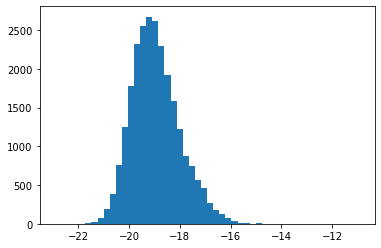

In [3]:
plt.hist(mags[:,0], bins=50)